<a href="https://colab.research.google.com/github/foxtrotmike/NODE/blob/master/node_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A Free Fall Dive into Neural Ordinary Differential Equations
By
##Fayyaz Minhas

The neural ordinary differential equation (NODE) paper [1] is a very interesting approach to developing new neural network models. However, at its core, it is a method that can learn the dynamics of a system in the form of a system of differential equations represented by a neural network. Sounds complicated? You will understand this by the time we are done with this tutorial. However, let's start off simple: by dropping an apple!

##Modeling Free Fall and Pendulums

Imagine an apple (in vaccum) of mass $m$  at given height $x(t)$ which is being acted on by gravity. We can model the instantaneous position $x(t)$ and velocity $v(t)=\dot{x}(t)=\frac{dx(t)}{dt}$ of the apple at any given time by considering the force acting on it, i.e.,

$F=ma=-mg$ 

which leads to 

$a = \frac{dv(t)}{dt}= \dot{v}(t)=-g$. 

Integrating this, we can get the instantaneous velocity of the apple:

$v(t)=\int_0^t dv(t)=v(0)+\int_0^t -gdt=v(0)-gt$ 

Integrating the velocity term, we can get the instantaneous position of the apple:

$x(t)=\int_0^t dx(t)=x(0)+\int_0^t v(t)dt=x(0)+\int_0^t (v(0)-gt)dt=x(0)+v(0)t-\frac{1}{2}gt^2$ 

Thus, the integration (or solution) of the following two differential equations, subject to the initial conditions x(0) and v(0), leads to the instantaneous velocity and position of the apple.

$\dot{x}(t)=v(t)$

$\dot{v}(t)=-g$

Position and velocity of this simple system determine the state $\mathbf x(t) = [x(t),v(t)]^T$ of the system: Given these variables, it is possible to analyze the time evolution of the dynamics of the system. Although not a requirement for understanding the rest of the tutorial, you can read more about the state space representation of dynamical systems here:  https://en.wikipedia.org/wiki/State-space_representation. 

In this case, the system of the two differential equations is very easy to solve analytically but it may not be the case for every system. As an example  consider a pendulum of mass $m$ and length $l$ with a pivot friction constant $k$. Its instantaneous angular position $x_1(t)=x(t)$ and angular velocity $x_2(t)=v(t)$ is described by the following two equations (a proof is not relevant here):

$\dot{x_1}(t)=v(t)=x_2(t)$

$\dot{x_2}(t)=\dot{v}(t)=-\frac{g}{l}sin(x(t))-\frac{k}{ml}v(t)=-\frac{g}{l}sin(x_1(t))-\frac{k}{ml}x_2(t)$

Now, this system, described by its state $\mathbf x(t) = [x_1(t),x_2(t)]^T$, can be quite difficult to integrate analytically. However, we can solve it numerically using an Ordinary Differential Equations (ODE) Solver which does numerical integration. Although, seemingly quite tricky, ODE solvers use the definition of derivative as $\frac{dg(t)}{dt}=\dot{g}(t) \approx \frac{g(t)-g(t-\Delta)}{\Delta}$ (for small $\Delta$) to solve for $g(t) \approx \Delta \dot{g}(t)+g(t-\Delta)$ using the initial value $g(0)$, knowledge of the value (not the analytical form) of the derivative $\dot{g}(t)$ and a for-loop. 

What we discussed above is a pretty naive ODE solver. There are others available which are more numerically stable with minimal error propagation properties such as the RK methods. However, for purposes of our discussion, the exact details of how they work are not relevant. The important thing is to understand that if we know the derivatives, we can use them to solve the state of the system (any system!). Conceptually: if we know the derivatives of a system's state $\frac{d\mathbf x(t)}{dt}$ and the initial value of its state $\mathbf x(0)$, we can the use an ODESolver subroutine to get (an approximation) of the state of the system: $\mathbf x(t) \approx ODESolver(\frac{d\mathbf x(t)}{dt},t,\mathbf x(0))$.


However, what to do if we don't know the differential equations of a system? Can we learn it from observations of the state?

## Learning ODEs

An alternate way of framing the question raised above is: If we know the state $\mathbf x_{obs}(t)$ of the system at a given time (say, we observe instanteneous position and velocity), then how can we get a representation of the system of differential equations $\frac{d\mathbf x(t)}{dt}$ such that if we solve the ODEs using an ODE solver (or analytically using a math guru), we get the same state at each time step as observed. In other words, we want to minimize the error or loss between the observed state and the output of the ODESolver based on the differential equations  $L(\mathbf x_{obs}(t),\frac{d\mathbf x(t)}{dt};t,\mathbf x(0))=\|\mathbf x_{obs}(t)-ODESolver(\frac{d\mathbf x(t)}{dt},t,\mathbf x(0))\|$. This is the problem that is solved using a neural network in the NODE paper. 

For this purpose, we consider a neural network $f(\mathbf x(t),t;\theta)$ with trainable parameters $\theta$ that generates differential equation outputs based on its own estimate of the state of the system at time $t$, i.e., we model $\frac{d\mathbf x(t)}{dt}=f(\mathbf x(t),t;\theta)$. This way, the above problem of learning the dynamics becomes one of learning the optimal weights $\theta$ of a neural network which can, in turn, be written as the following optimization problem:

$\theta^*=argmin_{\theta} \|\mathbf x_{obs}(t)-ODESolver(f(\mathbf x(t),t;\theta),t,\mathbf x(0))\|$

Looks complicated? Let's break it down: If we have a representation of the differential evolution of the state of the system, say $f(\mathbf x(t),t;\theta)$, then we can use an ODE solver to approximate the state $\mathbf x(t)$ of the system at any given time. We can then compare the generated state to the actual or observed state $\mathbf x_{obs}(t)$ of the system and use this error or loss signal to optimize the parameters $\theta$ through backpropagation. However, there is one hitch: the ODESolver is not differentiable so we cannot backpropagate our derivatives through it! Unless - we can implement a differentiable ODE solver! This is one contribution of the NODE paper. If you think about the naive ODE solver above, it is composed of simple mathematical operations so it shouldn't be too hard to implement in pytorch yourself while keeping it differentiable. However, the NODE paper people have done a better job: they have developed a method called the adjoint method that allows this to be implemented with lower overhead. You can look into the paper to see how this is done (and there is a simple proof in the appendix of how the differentiable ODESolver is built using the adjoint method). Below, we discuss this method but if you want to skip ahead to the implementation, that's okay too.

## Understanding the adjoint method (for single variables!)

To learn the optimal weight parameters, we need to find $\frac{dL}{d\theta}$. However, $L$ is a function of the final state of the system $\mathbf x(t)$. Thus,  Computing $\frac{dL}{d\theta}$ requires us to know how the loss changes with respect to the state $x(t)$, i.e., $\frac{dL}{dx(t)}$ and how $x(t)$ changes with respect to $\theta$. In other words, $\frac{d L}{d\theta}=\frac{dL}{d x(t)}\frac{dx(t)}{d\theta}$. This first quantity in this term is called the adjoint $a(t)=\frac{d L}{d x(t)}$. Since we have modeled the differential equation as $f(x(t),t;\theta)=\frac{dx(t)}{dt}$, therefore we can write the state at $t+\epsilon$ as:

$x(t+\epsilon)=x(t)+\int_t^{t+\epsilon}f(x(t),t;\theta)dt$

Thus, using the chain rule, we can write:

$\frac{dL}{dx(t)}=\frac{dL}{dx(t+\epsilon)}\frac{d x(t+\epsilon)}{d x(t)}$

or $a(t)=a(t+\epsilon) \frac{d}{d x(t)}(x(t)+\int_t^{t+\epsilon}f(x(t),t;\theta))\approx a(t+\epsilon)(1+\epsilon\frac{d f(x(t),t;\theta)}{d x(t)}) $

Thus,

$\frac{a(t+\epsilon)-a(t)}{\epsilon}=-a(t+\epsilon)\frac{d f(x(t),t;\theta)}{d x(t)}$

Under the limit $\epsilon \rightarrow 0^+$, we get:

$\frac{da(t)}{dt}=\lim_{\epsilon \rightarrow 0^+}\frac{a(t+\epsilon)-a(t)}{\epsilon}=-a(t)\frac{d f(x(t),t;\theta)}{d x(t)}$

This shows that we can calculate $a(t)=\frac{d L}{d x(t)}$ by solving the system of differential equations above using an ODESolver, i.e., $a(t)=\int da(t)$.

Once we get the $a(t)$, we can calculate the derivative:

$\frac{d L}{d\theta}=\frac{dL}{d x(t)}\frac{dx(t)}{d\theta}=a(t)\frac{dx(t)}{d\theta}=\int_t^0  \frac{da(t)}{dt}\frac{dx(t)}{d\theta}dt=-\int_t^0  a(t)\frac{d f(x(t),t;\theta)}{d x(t)}\frac{dx(t)}{d\theta}dt=-\int_t^0 a(t)\frac{d f(x(t),t;\theta)}{d \theta}dt$

Here, $\frac{d f(x(t),t;\theta)}{d \theta}$ is simply the derivative of the neural network output with respect to the weights. Notice that the integration is done from the last time step to the initial, i.e., we compute the state output and then do continuous backpropagation to the initial state. The authors have used a single call to an ODESolver to compute the adjoint and the system state by augmenting the different equations of the two leading to an efficient solution. 

## Implementation

Below, we use the awesome torchdiffeq package provided by the authors to learn the dyanmics of both free fall and pendulum systems! This package implements an ODE Solver called odeint and we modify a simple example provided by the authors for our purposes. 

We begin by first installing it. Then we write the true dynamics of the free fall and pendulum systems so we can generate training data of the states of these systems. This is done using the odesolver. However, in practice this data can come from sensor observations. We then use the NODE to learn a model. 








In [1]:
!pip install torchdiffeq

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 14 00:18:05 2020
This code contains all functions for NODE
@author: fayyaz
"""


import os
import argparse
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

class Args:
  method = 'dopri5'#adams
  data_size = 500
  batch_time = 10
  batch_size = 20
  niters = 1000
  test_freq = 20
  viz = True
  gpu = 0
  adjoint = True

args = Args()
if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')

#system differential equations for generating simulation data

#Free fall model
class FreeFall(nn.Module):
    def forward(self, t, y):        
        ydot = 0*y #just initialize the variable [x,v]
        ydot[0,0]=y[0,1] #xdot = v
        ydot[0,1]=-9.8 #vdot = -g
        return ydot
        #return torch.mm(y, true_A)+gg

#pendulum dynamics
class Pendulum(nn.Module):
    def forward(self, t, y):  
        #see : https://en.wikipedia.org/wiki/State-space_representation
        ydot = 0*y #just initialize the variable [x,v] (angular position, ang velocity)
        ydot[0,0]=y[0,1] # xdot = v
        ydot[0,1]=-200*torch.sin(y[0,0])-3.0*y[0,1] #vdot = -(g/l)sin(x(t))-kv(t)/(ml)
        return ydot
#predator prey
class LotkaVolterra(nn.Module):
    def forward(self, t, y):  
        #see : https://en.wikipedia.org/wiki/State-space_representation
        alpha,beta = 1.0,1.0
        delta,gamma = 1.0,1.0
        ydot = 0*y #just initialize the variable [x,v] (angular position, ang velocity)
        y = y
        x,y=y[0,0],y[0,1]
        ydot[0,0]=alpha*x-beta*x*y # xdot = v
        ydot[0,1]=delta*x*y-gamma*y
        return ydot


# for visualization
def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)


def visualize(true_y, pred_y, odefunc, itr, fig, ax_traj, ax_phase,ax_vecfield):
    xmax,ymax=torch.squeeze(torch.max(true_y,dim=0)[0]).cpu().detach().numpy()
    xmin,ymin=torch.squeeze(torch.min(true_y,dim=0)[0]).cpu().detach().numpy()
    veps=1e-1
    xmin,ymin=xmin-veps,ymin-veps
    xmax,ymax=xmax+veps,ymax+veps

    if args.viz:
        ax_traj.cla()
        ax_traj.set_title('Trajectories')
        ax_traj.set_xlabel('t')
        ax_traj.set_ylabel('x,y')
        ax_traj.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
        ax_traj.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--')
        ax_traj.set_xlim(t.min(), t.max())
        ax_traj.set_ylim(min(xmin,ymin), max(xmax,ymax))
        ax_traj.legend()

        ax_phase.cla()
        ax_phase.set_title('Phase Portrait')
        ax_phase.set_xlabel('x')
        ax_phase.set_ylabel('y')
        ax_phase.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
        ax_phase.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        ax_phase.set_xlim(xmin, xmax)
        ax_phase.set_ylim(ymin, ymax)

        ax_vecfield.cla()
        ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[ymin:ymax:21j, xmin:xmax:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2))).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag)
        dydt = dydt.reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")
        ax_vecfield.set_xlim(xmin, xmax)
        ax_vecfield.set_ylim(ymin, ymax)

        fig.tight_layout()
        plt.savefig('png/{:03d}'.format(itr))
        #plt.draw()
        display.clear_output(wait=True)
        display.display(fig)
        plt.pause(0.01)

# Neural network to model ODE
class NODE(nn.Module):

    def __init__(self):
        super(NODE, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 50),    
            nn.Tanh(),      #can model nonlinear odes  
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)


class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

def LearnODE(true_y,t):
    """
    takes true state of the system and time to learn a neural network ODE
    """
    # get a batch of training data  
    #(true_y contains the true dynamics)   
    #t contains time
    def get_batch():
        s = torch.from_numpy(np.random.choice(np.arange(args.data_size - args.batch_time, dtype=np.int64), args.batch_size, replace=False))
        batch_y0 = true_y[s]  # (M, D)
        batch_t = t[:args.batch_time]  # (T)
        batch_y = torch.stack([true_y[s + i] for i in range(args.batch_time)], dim=0)  # (T, M, D)
        return batch_y0, batch_t, batch_y
    if args.viz:
        makedirs('png')
        import matplotlib.pyplot as plt
        fig = plt.figure(figsize=(12, 4), facecolor='white')
        ax_traj = fig.add_subplot(131, frameon=False)
        ax_phase = fig.add_subplot(132, frameon=False)
        ax_vecfield = fig.add_subplot(133, frameon=False)
        plt.show(block=False)

    ii = 0

    func = NODE()
    optimizer = optim.Adam(func.parameters(), lr=1e-2)
    end = time.time()

    time_meter = RunningAverageMeter(0.97)
    loss_meter = RunningAverageMeter(0.97)

    for itr in range(1, args.niters + 1):
        optimizer.zero_grad()
        batch_y0, batch_t, batch_y = get_batch()
        pred_y = odeint(func, batch_y0, batch_t)
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()

        time_meter.update(time.time() - end)
        loss_meter.update(loss.item())

        if itr % args.test_freq == 0:
            with torch.no_grad():
                pred_y = odeint(func, true_y0, t)
                loss = torch.mean(torch.abs(pred_y - true_y))
                print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
                visualize(true_y, pred_y, func, ii, fig,ax_traj, ax_phase,ax_vecfield)
                ii += 1

        end = time.time()

    return func



###Free Fall Dynamics 

Below we generate (and then learn) the dynamics of free fall! We plot the position and velocity of the apple with respect to time as well as a phase plot (state variables against each other). We also plot the learned vector field which is simply the vector of derivatives for a given state based on the output of the neural network ODE Model. 

Notice that the object starts at an initial height and with an initial velocity and we learn the dynamics of the system over time. 

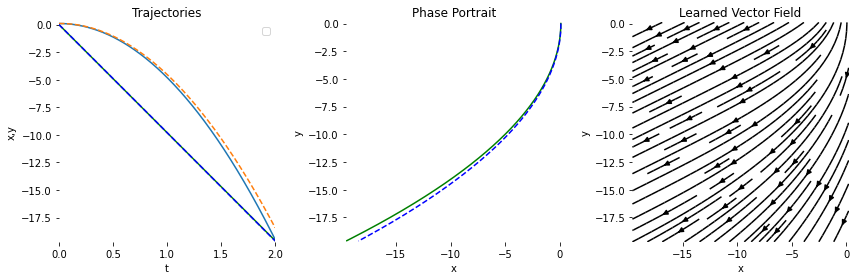

<Figure size 432x288 with 0 Axes>

In [3]:
true_y0 = torch.tensor([[0.1, 0.0]]) #initial state (x0,v0)
t = torch.linspace(0., 2., args.data_size) #time (t0,t1,steps)

#simulate the dynamics
sys = FreeFall()
with torch.no_grad():
    true_y = odeint(sys, true_y0, t, method='dopri5') # get target values (states at time steps)
model = LearnODE(true_y,t)

###Pendulum Dynamics

Below we generate (and then learn) the dynamics of a pendulum! Notice how the simulation of the pendulum generates a dampening oscillation due to friction and how the neural network learns the dynamics of the system. 



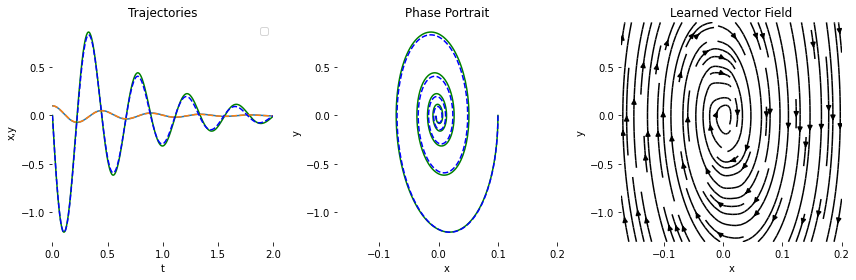

<Figure size 432x288 with 0 Axes>

In [4]:
true_y0 = torch.tensor([[0.1, 0.0]]) #(x0,v0)
t = torch.linspace(0., 2., args.data_size) #time (t0,t1,steps)

#simulate the dynamics
sys = Pendulum()
with torch.no_grad():
    true_y = odeint(sys, true_y0, t, method='dopri5') # get target values (states at time steps)
model = LearnODE(true_y,t)

## Infinite depth neural networks with NODE

If you think of a residual network layer $t$, it takes an input $h_{t-1}$ and produces $h_{t+1}=f(h_{t};\theta)+h_{t}$. Thus, the layer itself learns the residual or difference: $f(h_{t};\theta)=h_{t-1}-h_t$ which is then summed (integrated over one step) to produce the output $h_{t+1}=f(h_{t};\theta)+h_{t}$. 

In general, we can model it as a continous residual: $f(h(t),t;\theta)=\frac{dh(t)}{dt}$. What this means is that a (continuous) residual network layer is a representation of the derivatives, much like the differential equations describing a dynamical system above, which when integrated (through an ODESolver) would produce the target output. Imagine an image classification problem - we need to transform the features of the image to the target output (class label). The way a continuous residual network would do it is to take the input, pass it through the network to give the derivatives of the output with respect to the layer which when integrated through the ODESolver would yield an approximation of the target label. We can backpropagate this error signal to learn the optimal weights of the layer. And all this using a single continous layer (in constant memory!). However, since each step requires solving the ODEs, it may take time. The authors of the paper have interesting classification problems (MNIST etc.).


## Normalizing Flows

The paper also presents ideas on continuous normalizing flows. Normalizing flows allow us to model a target probability density function in terms of simple probability density functions in a reversible manner. Together with GANs and Autoencoder architectures, Normalizing flows are another way of generating data. However, in contrast to these methods, normalizing flows model the transformation explicity and are reversible, i.e., it is possible to see what factors in the input affect which outputs and so on. Normalizing flows use a change of variable equation which involves derivatives. You should first learn more about normalizing flows using this video: https://www.youtube.com/watch?v=i7LjDvsLWCg. The NODE paper builds on this to propose a continous normalizing flow method which works quite well in practice. 

## Further Reading and Pointers


[1] https://arxiv.org/abs/1806.07366

Learning Differential Equations that are Easy to Solve https://arxiv.org/abs/2007.04504 (with JAX!)

NODE in Julia: https://julialang.org/blog/2019/01/fluxdiffeq/

Graph NODE: https://arxiv.org/abs/1911.07532

Normalizing Flows: Kobyzev, Ivan, Simon Prince, and Marcus Brubaker. “Normalizing Flows: An Introduction and Review of Current Methods.” IEEE Transactions on Pattern Analysis and Machine Intelligence, 2020, 1–1. https://doi.org/10.1109/TPAMI.2020.2992934.

(c) Fayyaz Minhas.